## 試してみたいこと
- teacher-forcingじゃないバージョンをやってみる
- 2回目からdf_treeを使う
- VostingClassifierの中身を入れ替える
- binary->labelにする

昨日やったこと
- childreも特徴量として消す => だめ
- KStraitFoldのrandom_stateなどを消す => ほとんど変わらん

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.5MB/s 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [ ]:
# defact standard
import numpy as np
import pandas as pd
pd.set_option("max_rows", 500, "max_colwidth", 500, "max_columns", 500)
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 前処理
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.base import BaseEstimator, TransformerMixin

# モデル
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

# チューニング
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 評価
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score

In [ ]:
train_df = pd.read_csv("./train.csv")
print(train_df.shape)
train_df.head(15)

(1600, 8)


,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0
1,1,41,male,29.798725,1,no,southwest,0
2,2,28,male,32.722029,0,yes,northwest,1
3,3,20,female,38.429831,2,no,southeast,0
4,4,45,female,29.641854,1,no,northwest,0
5,5,20,male,37.785937,2,yes,southeast,1
6,6,37,male,43.393374,2,no,northeast,0
7,7,41,female,32.280407,1,no,northeast,0
8,8,40,male,28.865828,1,no,northeast,0
9,9,54,female,33.870887,2,no,northeast,0


# メモ
- そもそも保険の費用帯ってなに？
- 若い人より、お年寄りの方が高い？
- bmiが高い人ほど高い?
- 子供の数が多いほど高い?
- 喫煙者の方がもちろん高い？
- 地域によって関係あるか？

# 基礎集計

In [ ]:
train_df.isnull().sum()

id          0
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [ ]:
train_df.charges.value_counts()

0    1256
1     198
2     146
Name: charges, dtype: int64

### age

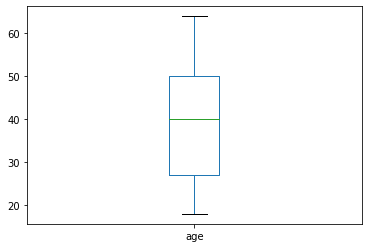

In [ ]:
train_df.age.plot.box()

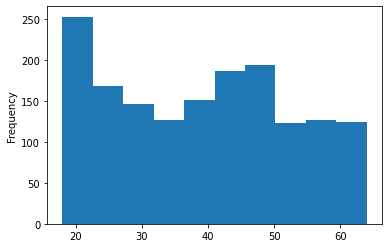

In [ ]:
train_df.age.plot.hist(bins=10)

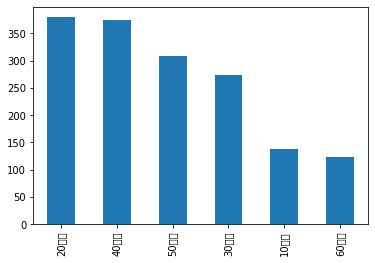

In [ ]:
train_df.age.apply(lambda x: "{}0歳代".format(x // 10)).value_counts().plot.bar()


### bmi

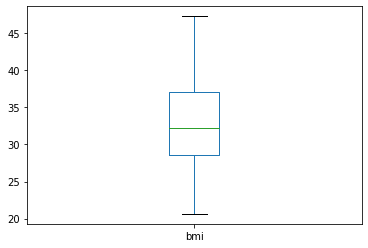

In [ ]:
train_df.bmi.plot.box()

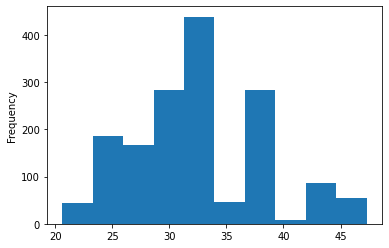

In [ ]:
train_df.bmi.plot.hist(bins=10)

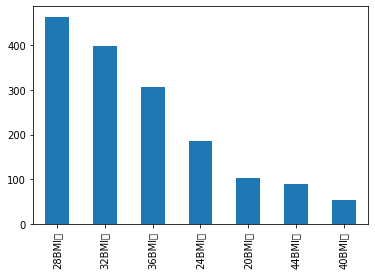

In [ ]:
train_df.bmi.apply(lambda x: "{}BMI代".format(int((x // 4) * 4))).value_counts().plot.bar()

In [ ]:
train_df.head()

,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0
1,1,41,male,29.798725,1,no,southwest,0
2,2,28,male,32.722029,0,yes,northwest,1
3,3,20,female,38.429831,2,no,southeast,0
4,4,45,female,29.641854,1,no,northwest,0


# 前処理

In [ ]:
# 年齢と性別を分割 => dataframe
class SplitBins(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
      return self
    def transform(self, X):
        DF = X.copy()
        DF["age"] = DF.age.apply(lambda x: "{}0歳代".format(x // 10))
        DF["bmi"] = DF.bmi.apply(lambda x: "{}BMI代".format(int((x // 4) * 4)))
        return DF

In [ ]:
# 列ごとにstandardscaler => dataframe
class SplitStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=[]):
      self.columns = columns
      self.ss = StandardScaler()
    def fit(self, X):
      self.ss.fit(X[self.columns])
      return self
    def transform(self, X):
        DF = X.copy()
        DF[self.columns] = self.ss.transform(DF[self.columns])
        return DF

In [ ]:
# LR, NN, KNN用パイプライン
nn_pipeline = Pipeline([
  ("ohe", ce.BinaryEncoder(cols=["sex", "smoker", "region"], handle_unknown="ignore")),
  ("ss", SplitStandardScaler(columns=["age", "bmi", "children"]))
])

In [ ]:
# Tree系用パイプライン
tree_pipeline = Pipeline([
  ("split_bins", SplitBins()),
  ("le", ce.OrdinalEncoder(cols=["age", "sex", "bmi", "smoker", "region"]))
])

In [ ]:
train_df_nn = nn_pipeline.fit_transform(train_df)
train_df_nn.drop(columns=["id"], inplace=True)
# 3値分類を(2値分類 => 2値分類)にするための処理
train_df_nn["pred"] = train_df_nn.charges.apply(lambda x: x if x == 0 else 1)
train_df_nn.head()

,age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,charges,pred
0,-0.958248,0,1,0.041819,1.577599,0,1,0,0,1,0,0
1,0.148700,0,1,-0.455438,-0.011421,0,1,0,1,0,0,0
2,-0.810655,0,1,0.051630,-0.805931,1,0,0,1,1,1,1
3,-1.401027,1,0,1.041689,0.783089,0,1,0,0,1,0,0
4,0.443886,1,0,-0.482648,-0.011421,0,1,0,1,1,0,0


In [ ]:
train_df_tree = tree_pipeline.fit_transform(train_df)
train_df_tree
# 3値分類を(2値分類 => 2値分類)にするための処理
train_df_tree["pred"] = train_df_tree.charges.apply(lambda x: x if x == 0 else 1)
train_df_tree.head()

,id,age,sex,bmi,children,smoker,region,charges,pred
0,0,1,1,1,3,1,1,0,0
1,1,2,1,2,1,1,2,0,0
2,2,1,1,1,0,2,3,1,1
3,3,1,2,3,2,1,1,0,0
4,4,2,2,2,1,1,3,0,0


## 学習 step1

In [ ]:
exclude_columns = ["sex_0", "sex_1", "region_0", "region_1", "region_2","charges", "pred"]
X_train1 = train_df_nn[train_df_nn.columns.difference(exclude_columns)]
y_train1 = train_df_nn.pred

### ロジスティック回帰

In [ ]:
lr_param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.03, 0.1, 1, 3, 10],
}
gs_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True))
# gs_lr.fit(X_train1, y_train1)
# print("---")
# gs_lr.best_params_, gs_lr.best_score_

In [ ]:
# for k,v in zip(X_train1.columns, gs_lr.best_estimator_.coef_[0]):
#   print(k, v)

### KNN

In [ ]:
knn_param_grid = {
    "n_neighbors": [1, 3, 4, 5, 6, 7, 10, 30, 50],
    "p": [1, 2]
}
gs_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True))
# gs_knn.fit(X_train1, y_train1)
# print("---")
# gs_knn.best_params_, gs_knn.best_score_

### NN

In [ ]:
nn_param_grid = {
    "hidden_layer_sizes": [(10,),(30,), (50, ), (100, ),(30, 30)],
    "activation": ["tanh", "relu"],
    "alpha": [0.01, 0.1, 0.3, 1],
    "early_stopping": [True, False]
}
gs_mlp = GridSearchCV(
    estimator=MLPClassifier(random_state=41),
    param_grid=nn_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))
# gs_mlp.fit(X_train1, y_train1)
# print("---")
# gs_mlp.best_params_, gs_mlp.best_score_

### RandomForest

In [ ]:
rfc_param_grid = {
    "n_estimators": [10, 30, 50, 100],
    "max_depth": [2, 3, 5, 7],
    "min_samples_split": [2, 10, 30],
    "max_leaf_nodes": [10, 20, 30, 40]
}
gs_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=41),
    param_grid=rfc_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=1230, shuffle=True))
# gs_rfc.fit(X_train1, y_train1)
# print("---")
# gs_rfc.best_params_, gs_rfc.best_score_

In [ ]:
# for k, v in zip(X_train1.columns, gs_rfc.best_estimator_.feature_importances_):
#     print(k, v)

### Newton Boosting

In [ ]:
lgbm_param_grid = {
    "n_estimator": [10, 30, 50,100],
    "max_depth": [3,5,7,9],
    "num_leaves": [3,5,7,9],
    "min_child_samples": [10, 20, 30],
    "min_child_weight": [0.001, 0.003, 0.01, 0.03],
    "learning_rate": [0.03, 0.1]
}
gs_lgbm = GridSearchCV(
    estimator=LGBMClassifier(random_state=41),
    param_grid=lgbm_param_grid,scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True))
# gs_lgbm.fit(X_train1, y_train1)
# print("---")
# gs_lgbm.best_params_, gs_lgbm.best_score_

In [ ]:
# for k, v in zip(X_train1.columns, gs_lgbm.best_estimator_.feature_importances_):
#     print(k, v)

In [ ]:
# アンサンブル
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(
    estimators=[
                ("lr", gs_lr),
                ("knn", gs_knn),
                ("mlp", gs_mlp),
                ("rfc", gs_rfc),
                ("lgm", gs_lgbm)
                ], voting="soft")
vc.fit(X_train1, y_train1)

VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                                           error_score=nan,
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
          

In [ ]:
f1_score(train_df.charges.apply(lambda x: x if x == 0 else 1), vc.predict(train_df_nn[train_df_nn.columns.difference(exclude_columns)]), average="macro")

0.8664809009636596

## 学習 step2

In [ ]:
train_df_nn.head()

,age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,charges,pred
0,-0.958248,0,1,0.041819,1.577599,0,1,0,0,1,0,0
1,0.148700,0,1,-0.455438,-0.011421,0,1,0,1,0,0,0
2,-0.810655,0,1,0.051630,-0.805931,1,0,0,1,1,1,1
3,-1.401027,1,0,1.041689,0.783089,0,1,0,0,1,0,0
4,0.443886,1,0,-0.482648,-0.011421,0,1,0,1,1,0,0


In [ ]:
train_df_nn2 = train_df_nn.query("charges != 0")
train_df_nn2.head()

,age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,charges,pred
2,-0.810655,0,1,0.051630,-0.805931,1,0,0,1,1,1,1
5,-1.401027,0,1,0.930001,0.783089,1,0,0,0,1,1,1
21,0.960462,1,0,0.108016,-0.805931,0,1,0,1,0,1,1
35,-1.548620,0,1,0.873370,-0.805931,0,1,0,0,1,1,1
48,0.591479,0,1,-0.492195,-0.011421,1,0,0,1,1,1,1


In [ ]:
X_train2 = train_df_nn2[train_df_nn2.columns.difference(exclude_columns)]
y_train2 = train_df_nn2.charges

In [ ]:
gs_lr2 = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=lr_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True))
# gs_lr2.fit(X_train2,  y_train2)
# print("---")
# gs_lr2.best_params_, gs_lr2.best_score_

In [ ]:
# for k,v in zip(X_train2.columns, gs_lr2.best_estimator_.coef_[0]):
#   print(k, v)

In [ ]:
gs_knn2 = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True))
# gs_knn2.fit(X_train2,  y_train2)
# print("---")
# gs_knn2.best_params_, gs_knn2.best_score_

In [ ]:
gs_mlp2 = GridSearchCV(
    estimator=MLPClassifier(random_state=41),
    param_grid=nn_param_grid,
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))
# gs_mlp2.fit(X_train2,  y_train2)
# print("---")
# gs_mlp2.best_params_, gs_mlp2.best_score_

In [ ]:
gs_rfc2 = GridSearchCV(
    estimator=RandomForestClassifier(random_state=41),
    param_grid=rfc_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=1230, shuffle=True))
# gs_rfc2.fit(X_train2,  y_train2)
# print("---")
# gs_rfc2.best_params_, gs_rfc2.best_score_

In [ ]:
# for k, v in zip(X_train2.columns, gs_rfc2.best_estimator_.feature_importances_):
#     print(k, v)

In [ ]:
gs_lgbm2 = GridSearchCV(
    estimator=LGBMClassifier(random_state=41),
    param_grid=lgbm_param_grid, scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=2020, shuffle=True))
# gs_lgbm2.fit(X_train2,  y_train2)
# print("---")
# gs_lgbm2.best_params_, gs_lgbm2.best_score_

In [ ]:
# for k, v in zip(X_train2.columns, gs_lgbm2.best_estimator_.feature_importances_):
#     print(k, v)

In [44]:
vc2 = VotingClassifier(
    estimators=[
                ("lr", gs_lr2),
                ("knn", gs_knn2),
                ("mlp", gs_mlp2),
                ("rfc", gs_rfc2),
                ("lgm", gs_lgbm2)
                ], voting="soft")
vc2.fit(X_train2, y_train2)

VotingClassifier(estimators=[('lr',
                              GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                                           error_score=nan,
                                           estimator=LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='auto',
                                                                        n_jobs=None,
          

In [45]:
pred = vc2.predict(X_train2)
f1_score(train_df_nn2.charges, pred, average="macro")

0.8512522485125225

## 訓練データ予測

In [46]:
train_df_nn["pred"] = vc.predict(train_df_nn[train_df_nn.columns.difference(exclude_columns)])
train_df_nn2 = train_df_nn.query("pred != 0")
train_df_nn.loc[train_df_nn.pred != 0, "pred"] = vc2.predict(train_df_nn2[train_df_nn2.columns.difference(exclude_columns)])
f1_score(train_df_nn.charges, train_df_nn.pred, average="macro")

0.7590448025312275

## テストデータ予測

In [47]:
test_df = pd.read_csv("./test.csv")
test_df["pred"] = 0
print(test_df.shape)
test_df.head()

(400, 8)


,id,age,sex,bmi,children,smoker,region,pred
0,13,19,male,24.365178,1,no,northeast,0
1,23,59,male,33.997763,0,yes,northeast,0
2,27,42,female,29.283450,0,no,southwest,0
3,28,30,male,24.903725,1,no,northwest,0
4,29,41,female,29.644536,0,no,southwest,0


In [48]:
test_df = nn_pipeline.transform(test_df)
test_df.drop(columns=["id"], inplace=True)
test_df.head()

,age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,pred
0,-1.474823,0,1,-1.397926,-0.011421,0,1,1,0,0,0
1,1.477037,0,1,0.272915,-0.805931,1,0,1,0,0,0
2,0.222496,1,0,-0.544816,-0.805931,0,1,0,1,0,0
3,-0.663062,0,1,-1.304511,-0.011421,0,1,0,1,1,0
4,0.148700,1,0,-0.482183,-0.805931,0,1,0,1,0,0


In [49]:
test_df["pred"] = vc.predict(test_df[test_df.columns.difference(exclude_columns)])
test_df.head()

,age,sex_0,sex_1,bmi,children,smoker_0,smoker_1,region_0,region_1,region_2,pred
0,-1.474823,0,1,-1.397926,-0.011421,0,1,1,0,0,0
1,1.477037,0,1,0.272915,-0.805931,1,0,1,0,0,1
2,0.222496,1,0,-0.544816,-0.805931,0,1,0,1,0,0
3,-0.663062,0,1,-1.304511,-0.011421,0,1,0,1,1,0
4,0.148700,1,0,-0.482183,-0.805931,0,1,0,1,0,0


In [50]:
test_df2 = test_df.query("pred != 0")
test_df.loc[test_df.pred != 0, "pred"] = vc2.predict(test_df2[test_df2.columns.difference(exclude_columns)])
test_df.pred.value_counts()

0    330
2     36
1     34
Name: pred, dtype: int64

In [51]:
submit = pd.read_csv("./test.csv")
submit["pred"] = test_df.pred
submit[["id", "pred"]].to_csv("./submit.csv", header=None, columns=None, index=None)

In [52]:
pd.read_csv("./submit.csv", header=None).head()

,0,1
0,13,0
1,23,2
2,27,0
3,28,0
4,29,0


In [53]:
files.download('./submit.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>